In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import h5py
from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, AveragePooling1D
from keras import backend as K

Using TensorFlow backend.


### 0. parameters

In [2]:
num_classes = 3
num_dims = 4
epochs = 50
batch_size=10

### 1. Data loading and reconstruction

In [5]:
training_file = '../data/training set/trend-40day-absdiff.h5'
file = h5py.File(training_file, 'r')

In [14]:
X, Y = file['X'].value, file['Y'].value

In [17]:
Y = keras.utils.to_categorical(Y, num_classes)

In [56]:
#train data
length = int(len(X)*0.7)
x_train, x_test = X[:length], X[length:]
y_train, y_test = Y[:length], Y[length:]

#verification
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (233, 20, 4)
233 train samples
101 test samples


### 2. Construct Model

In [9]:
input_shape = X.shape[1:]

In [10]:
model = Sequential()
model.add(Conv1D(32, 3, input_shape=input_shape, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, activation='relu'))
#model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 3. Train

In [19]:
model.fit(X, Y, batch_size=16, epochs=50, verbose=1)

Epoch 1/50
503/503 [==============================] - 1s - loss: 0.0147 - acc: 0.9940     
Epoch 2/50
503/503 [==============================] - 1s - loss: 0.0256 - acc: 0.9901     
Epoch 3/50
503/503 [==============================] - 2s - loss: 0.0147 - acc: 0.9920     
Epoch 4/50
503/503 [==============================] - 1s - loss: 0.0163 - acc: 0.9920     
Epoch 5/50
503/503 [==============================] - 1s - loss: 0.0070 - acc: 0.9980     
Epoch 6/50
503/503 [==============================] - 1s - loss: 0.0078 - acc: 0.9980     
Epoch 7/50
503/503 [==============================] - 1s - loss: 0.0249 - acc: 0.9901     
Epoch 8/50
503/503 [==============================] - 1s - loss: 0.0129 - acc: 0.9920     
Epoch 9/50
503/503 [==============================] - 1s - loss: 0.0091 - acc: 0.9960     
Epoch 10/50
503/503 [==============================] - 1s - loss: 0.0029 - acc: 0.9980     
Epoch 11/50
503/503 [==============================] - 1s - loss: 0.0076 - acc: 0.9960   

### 4. Accuracy

In [62]:
score = model.evaluate(x_test, y_test, verbose=1)

 32/101 [========>.....................] - ETA: 0s

In [63]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.26175946292
Test accuracy: 0.792079209101


### 5. Save to File

In [2]:
save_path = '../data/keras models/40day-trend.h5'

In [23]:
model.save(save_path)

In [3]:
model = keras.models.load_model(save_path)

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 38, 32)            416       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 64)            6208      
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 34, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1114368   
__________

### 6. Test Real Data

In [27]:
from IPython.display import clear_output
import time
from glob import glob
from modules.factory import ohlc_chart, norm

In [26]:
FILES = glob('../data/daily futures/*.csv')

../data/daily futures\ICE Coffee C.csv


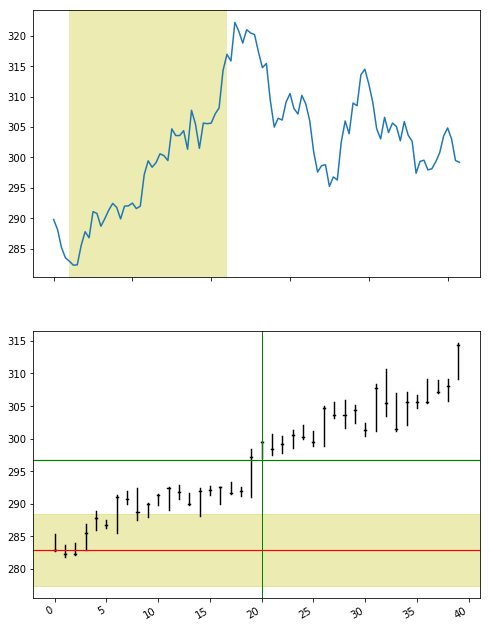

pred: 2
[[ 0.  0.  1.]]
q


In [29]:
WINDOW = 40
while True:
    idx = np.random.randint(0, len(FILES))

    raw_data  = pd.read_csv(FILES[idx])
    raw_data.drop(['Date', 'Volume','Prev. Day Open Interest'], axis=1, inplace=True)
    length = len(raw_data)
    
    
    for i in range(10):
        print(FILES[idx])
        #시작일자 랜덤 설정
        start = np.random.randint(0, length -  WINDOW)
        end = start + WINDOW
        data= raw_data[start:end]
            
        #Data Normalization
        base = np.abs(data.diff()).mean()
        data = norm(data)
        
        #그래프 
        fig, (ax) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 1]}, figsize=(8,12))
        fig.autofmt_xdate()
        
        if start < 240:
            start0 = 0
        else:
            start0 = start - 240
            
        if end + 60 < len(raw_data):
            end0 = end + 60
        else:
            end0 = len(raw_data)
        
        ax[0].plot(raw_data.index.values[start0:end0], raw_data.Settle.values[start0:end0])
        ax[0].axvspan(raw_data.index.values[start], raw_data.index.values[end], facecolor='y', alpha=0.3)
        
        ohlc_data = np.concatenate((np.arange(len(data)).reshape(-1, 1), raw_data[start:end].values), axis=1)
        #ax[1].plot(data.index.values, data.values)
        ohlc_chart(ax[1], ohlc_data, linewidth=1.44)
        mean = raw_data[start:end].Settle.mean()
        ax[1].axhline(y=mean, linewidth=1.2, color='g')
        ymin = raw_data.Open.iloc[start]-base.Settle*3
        ymax = raw_data.Open.iloc[start]+base.Settle*3
        ax[1].axhspan(ymin, ymax, alpha=0.3, color='y')
        ax[1].axhline(y=raw_data.Open.iloc[start], linewidth=1.2, color='red')
        ax[1].axvline(x=int(len(data)/2), linewidth=1, color='g')
        plt.show()
        
        #추세
        time.sleep(0.1)
        
        #temp = data.values.T
        #test_data = np.stack( (temp[0::4, :], temp[1::4, :], temp[2::4, :], temp[3::4, :]), axis=-1)
        pred = model.predict(np.array([data.values]))
    
        print('pred:', np.argmax(pred[0]))
        print(np.round(pred,3))
        #print('prob: ', np.round(sess.run(tf.nn.softmax(pred)),3))
        key = input()
        
        clear_output(wait=True)
        if key == 'q':
            break
    if key == 'q':
            break
    clear_output(wait=True)

In [77]:
np.array([data.values]).shape

(1, 20, 4)